# Natural Language Processing for the Fake News Challenge

## Main Imports

In [8]:
import torch
import string
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

!pip install transformers
import transformers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Set up the data for preprocessing

### Load the data

In [2]:
main_path = '/content/drive/My Drive/University Work/Year 4/Natural Language Processing/'
data_folder_name = 'data/'

train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'
test_body_filename = 'competition_test_bodies.csv'
test_stance_filename = 'competition_test_stances.csv'

train_body_path = main_path + data_folder_name + train_body_filename 
train_stance_path = main_path + data_folder_name + train_stance_filename
test_body_path = main_path + data_folder_name + test_body_filename
test_stance_path = main_path + data_folder_name + test_stance_filename

train_body_data = pd.read_csv(train_body_path)
train_stance_data = pd.read_csv(train_stance_path)
test_body_data = pd.read_csv(test_body_path)
test_stance_data = pd.read_csv(test_stance_path)

### Data Preprocessing

In [3]:
def preprocess(text):

    text = nltk.tokenize.word_tokenize(text)
    text = [word for word in text if word not in nltk.corpus.stopwords.words('english')]
    text = (" ").join(text)

    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    ps = nltk.stem.PorterStemmer()
    text = nltk.tokenize.word_tokenize(text)

    text = [ps.stem(word) for word in text]
    text = (" ").join(text)

    return text

In [4]:
train_body_data['articleBody'] = train_body_data['articleBody'].apply(lambda x: preprocess(x))
train_stance_data['Headline'] = train_stance_data['Headline'].apply(lambda x: preprocess(x))
test_body_data['articleBody'] = test_body_data['articleBody'].apply(lambda x: preprocess(x))
test_stance_data['Headline'] = test_stance_data['Headline'].apply(lambda x: preprocess(x))

### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies with a Relevance column

In [5]:
train_total_data = pd.merge(train_body_data, train_stance_data, on='Body ID')
train_total_data['Relevance'] = np.where(train_total_data['Stance'] == 'unrelated', 0, 1)

test_total_data = pd.merge(test_body_data, test_stance_data, on='Body ID')
test_total_data['Relevance'] = np.where(test_total_data['Stance'] == 'unrelated', 0, 1)

train_total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
42691,2223,piper jaffray ’ gene munster issu new report i...,india 400 men cut testicl get closer god follo...,unrelated,0
44543,2299,A new survey ub suggest appl watch could get s...,doe isi have ebola probabl not media report It...,unrelated,0
1315,61,north korean leader kim jong Un firm control g...,wa the batmobil stolen In detroit,unrelated,0
31700,1772,amazon may ventur beyond world onlin retail se...,jose canseco accident shot himself hand,unrelated,0
28342,1584,banksi appear share messag sorrow hope wednesd...,No banksi did nt creat that charli hebdo tribu...,discuss,1
30691,1708,word durex roll pumpkinspiceflavor condom swep...,tropic spider burrow man s skin appendix scar ...,unrelated,0
38149,2034,when report went viral nbc meteorologist mike ...,If realli believ colorado kfc sell pot ’ reali...,unrelated,0
944,40,young north korean dictat kim jong Un ’ health...,media outlet identifi jihadi john,unrelated,0
45321,2328,thi possibl best resign letter I ’ ever seen N...,alshabaab cofound confirm kill US air strike s...,unrelated,0
14139,844,planetari align On jan 4 2015 will decreas gra...,alleg audio michael brown shoot releas,unrelated,0


### Splitting the dataset into train and validation sets

In [9]:
train_input_columns = train_total_data[['Headline', 'articleBody']]
test_input_columns = test_total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(train_input_columns, train_total_data[target].values, test_size=0.20, random_state=0)

X_test = test_total_data[['Headline', 'articleBody']]
y_test = test_total_data[['Relevance']].to_numpy().ravel()

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)
print('Size of testing set:', X_test.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)
Size of testing set: (25413, 2)


,Headline,articleBody
5747,former british rapper reportedli under investi...,british intellig agenc mi5 mi6 identifi man su...
36656,turkish leader say US airdrop aid isi milit,there middl field bake sun cach grenad rocket ...
11945,daash ebola transfer mosul googl translat,amazon go open brickandmortar store new york c...
6046,homeless man becam youtub sensat spend 100 foo...,there long specul mythic creatur latest clip c...
1231,dog found abandon scottish train station suitc...,A nun live italian convent given birth surpris...
20776,break isi use chemic weapon – murder 300 iraqi...,balad iraq — dizzi vomit struggl breath 11 ira...
6954,isi behead photojournalist jame wright foley m...,jame wright foley american journalist kidnap 2...
4046,fidel castro dead ye He is… but the cuban lead...,lago — A wave violenc hour nigeria s govern an...
19922,world s oldest burger,multipl unconfirm sourc report hain behead isi
19871,meteorit leav crater nicaraguan capit managua,support islam state iraq syria milit group rec...


## Evaluation Metrics

### Confusion Matrix

In [ ]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [ ]:
# ROC Curve
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Display Classification Accuracies over results and plot Confusion Matrix and ROC Curve results

In [ ]:
def display_results(y_pred, y_val):

    # print classification report and plot confusion matrix and ROC curve
    print(classification_report(y_val, y_pred))
    plot_confusion_matrix(y_val, y_pred)
    plot_roc_curve(y_val, y_pred)

## Feature Extraction

### TF-IDF Feature Extraction

#### Custom Transformer for Pipeline

In [ ]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

#### Pipelines and Feature Union of Headline and Article Body

In [ ]:
min_df = 4
max_df = 0.5
max_features = 500

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=min_df, max_df=max_df, max_features=max_features, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=min_df, max_df=max_df, max_features=max_features, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
tfidf_train = preprocessor.fit_transform(X_train).todense()
tfidf_val = preprocessor.transform(X_val).todense()
tfidf_test = preprocessor.transform(X_test).todense()
print('Train size:', tfidf_train.shape)
print('Val size:  ', tfidf_val.shape)
print('Test size: ', tfidf_test.shape)

Train size: (39977, 1000)
Val size:   (9995, 1000)
Test size:  (25413, 1000)


### BERT Embeddings Extraction

#### Load the model and tokeniser

In [7]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Compute BERT Embeddings of Headline + Body pairs

In [ ]:
def get_bert_embeddings(bert_model, data, batch_size):

    # set device and lambda function for classification token retrieval
    device = torch.device("cuda")
    get_cls_token_embeddings = lambda x: x[0][:, 0, :].squeeze()
    bert_embeddings = []  # initialise embeddings
    #bert_embeddings = torch.load(main_path + 'bert_train.pt')


    for i in range(batch_size, data.shape[0] + batch_size, batch_size):

        # tokenise
        tokenized = tokenizer(list(data['Headline'][i - batch_size:i]), list(data['articleBody'][i - batch_size:i]),\
                          padding='max_length', truncation=True, return_tensors="pt")
        
        # get input ids and set to device
        tokenized_text = tokenized['input_ids']
        tokenized_text = tokenized_text.to(device)

        # calculate embeddings and retrieve cls token embedding
        with torch.no_grad():
            word_embeddings = bert_model(tokenized_text)

        hidden_state = word_embeddings[0].cpu()

        # append to total embeddings
        if bert_embeddings == []:
            bert_embeddings = hidden_state
        else:
            bert_embeddings = torch.cat((bert_embeddings, hidden_state), 0)

        # clear cache and GPU memory
        del word_embeddings
        torch.cuda.empty_cache()

        if i % 100 == 0:
            print("Batch", i)
        if i % 3200 == 0:
            print("Batch", i)
            torch.save(bert_embeddings.clone(), main_path + 'bert_train.pt')
            break

    return bert_embeddings

#### Retrieve BERT Embeddings for train, validation and test sets

In [ ]:
device = torch.device("cuda")
bert_model = bert_model.to(device)
batch_size = 64

print("===Training Set===")
bert_train = get_bert_embeddings(bert_model, X_train, batch_size)
#bert_train = torch.load(main_path + 'bert_train.pt')

#print("===Validation Set===")
#bert_val = get_bert_embeddings(bert_model, X_val, batch_size)
#torch.save(bert_val, main_path + 'bert_val.pt')

#print("===Testing Set===")
#bert_test = get_bert_embeddings(bert_model, X_test, batch_size)
#torch.save(bert_test, main_path + 'bert_test.pt')

===Training Set===
Batch 1600
Batch 3200
Batch 3200


#### Load BERT Embeddings for train, validation and test sets

In [ ]:
# load, detach from GPU, and convert to numpy arrays
bert_train = torch.load(main_path + 'bert_train.pt').detach().cpu().numpy()
bert_val = torch.load(main_path + 'bert_val.pt').detach().cpu().numpy()
bert_test = torch.load(main_path + 'bert_test.pt').detach().cpu().numpy()

EOFError: ignored

## Related/Unrelated Classification

### Machine Learning Models

#### Train Random Forest (RF) Classifier using TF-IDF Features and display results

In [ ]:
tfidf_RF_model = RandomForestClassifier(random_state=0, max_features=150).fit(tfidf_train, y_train)
tfidf_RF_model.score(tfidf_test, y_test)

0.7569354267500885

              precision    recall  f1-score   support

           0       0.77      0.94      0.85     18349
           1       0.64      0.29      0.40      7064

    accuracy                           0.76     25413
   macro avg       0.71      0.61      0.62     25413
weighted avg       0.74      0.76      0.72     25413



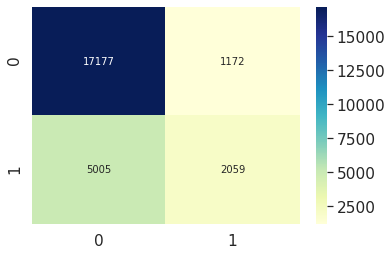

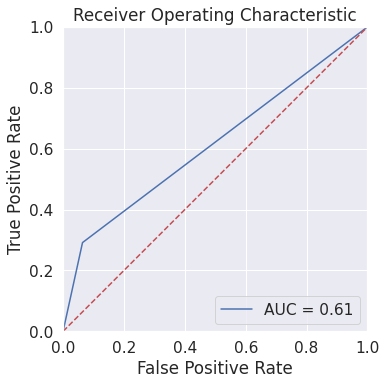

In [ ]:
y_pred = tfidf_RF_model.predict(tfidf_test)
display_results(y_pred, y_test)

#### Train Random Forest (RF) Classifier using BERT Embeddings and display results

In [ ]:
bert_RF_model = RandomForestClassifier(random_state=0, max_features=115).fit(bert_train, y_train)
bert_RF_model.score(bert_test, y_test)

0.6911816786683981

              precision    recall  f1-score   support

           0       0.74      0.88      0.81     18349
           1       0.39      0.19      0.26      7064

    accuracy                           0.69     25413
   macro avg       0.56      0.54      0.53     25413
weighted avg       0.64      0.69      0.65     25413



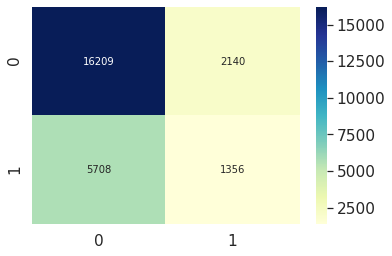

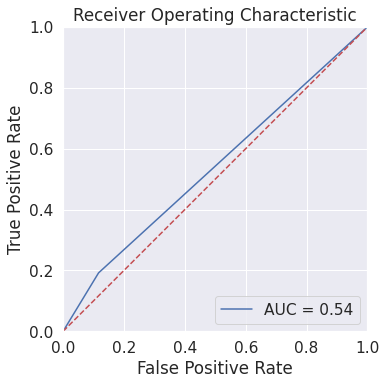

In [ ]:
y_pred = bert_RF_model.predict(bert_test)
display_results(y_pred, y_test)

### Deep Learning Models

#### Train a Multi-Layer Perceptron (MLP) on TF-IDF Embeddings

##### Define the MLP

In [ ]:
tfidf_MLP = Sequential()
tfidf_MLP.add(Dense(256, activation='relu', input_dim=1000))
tfidf_MLP.add(Dense(128, activation='relu'))
tfidf_MLP.add(Dense(64, activation='relu'))
tfidf_MLP.add(Dense(1, activation='sigmoid'))
tfidf_MLP.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
print(tfidf_MLP.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_65 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_66 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 65        
Total params: 297,473
Trainable params: 297,473
Non-trainable params: 0
_________________________________________________________________
None


##### Train the MLP

In [ ]:
batch_size = 32
tfidf_MLP.fit(tfidf_train, y_train, batch_size=batch_size,
        epochs=10, validation_data=(tfidf_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 5s 3ms/step - loss: 0.3258 - accuracy: 0.8544 - val_loss: 0.0542 - val_accuracy: 0.9802
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0221 - accuracy: 0.9923 - val_loss: 0.0434 - val_accuracy: 0.9836
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.0410 - val_accuracy: 0.9870
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0362 - val_accuracy: 0.9871
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0357 - val_accuracy: 0.9886
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0405 - val_accuracy: 0.9892
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0417 - val_accuracy:

##### Display Results of MLP on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.86      0.76      0.80     18349
           1       0.52      0.67      0.58      7064

    accuracy                           0.73     25413
   macro avg       0.69      0.71      0.69     25413
weighted avg       0.76      0.73      0.74     25413



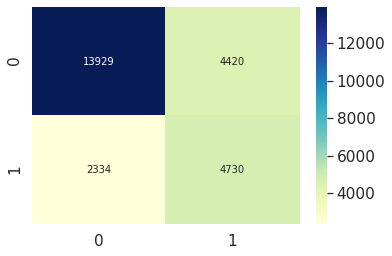

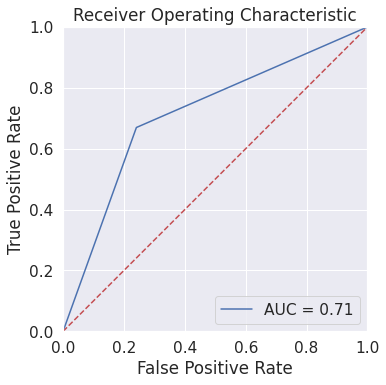

In [ ]:
y_pred = (tfidf_MLP.predict(tfidf_test) > 0.5).astype("int32")
display_results(y_pred, y_test)

#### Train a Bidirectional Long Short Term Memory (BI-LSTM) model on BERT Embeddings

##### Define the LSTM

In [ ]:
# https://stackoverflow.com/questions/62281260/how-to-use-cnn-and-lstm-for-nlp-with-bert-embeddings
reshaped_bert_train = bert_train.reshape(-1, 768, 1)
reshaped_bert_val = bert_val.reshape(-1, 768, 1)

bert_LSTM = Sequential()
bert_LSTM.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(768, 1)))
bert_LSTM.add(Bidirectional(LSTM(units=64)))
bert_LSTM.add(Dense(256, activation='relu'))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(128, activation='relu'))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.001)

bert_LSTM.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])
bert_LSTM.summary()

torch.Size([131072, 768, 1])
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 768, 256)          133120    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)          

##### Train the LSTM

In [ ]:
batch_size = 32
unrelated, related = np.bincount(train_total_data['Relevance'])
total = unrelated + related

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

unrelated_weight = (1 / unrelated)*(total)/2.0 
related_weight = (1 / related)*(total)/2.0
class_weights = {0: unrelated_weight, 1: related_weight}

model_save_file = main_path + data_folder_name + "new_bert_LSTM.hdf5"
checkpoint = ModelCheckpoint(model_save_file, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=10000)

history = bert_LSTM.fit(reshaped_bert_train, y_train, batch_size=batch_size,
                        epochs=200, validation_data=(reshaped_bert_val, y_val),
                        callbacks=[checkpoint], class_weight=class_weights)

Epoch 1/200
1250/1250 [==============================] - 190s 136ms/step - loss: 0.6934 - accuracy: 0.5093 - val_loss: 0.7076 - val_accuracy: 0.2768
Epoch 2/200
1250/1250 [==============================] - 173s 138ms/step - loss: 0.6895 - accuracy: 0.5475 - val_loss: 0.6832 - val_accuracy: 0.5696
Epoch 3/200
1250/1250 [==============================] - 173s 138ms/step - loss: 0.6813 - accuracy: 0.5971 - val_loss: 0.6764 - val_accuracy: 0.6366
Epoch 4/200
1250/1250 [==============================] - 171s 137ms/step - loss: 0.6809 - accuracy: 0.6064 - val_loss: 0.6824 - val_accuracy: 0.6098
Epoch 5/200
1250/1250 [==============================] - 175s 140ms/step - loss: 0.6784 - accuracy: 0.6267 - val_loss: 0.6588 - val_accuracy: 0.6804
Epoch 6/200
1250/1250 [==============================] - 175s 140ms/step - loss: 0.6748 - accuracy: 0.6521 - val_loss: 0.6855 - val_accuracy: 0.6420
Epoch 7/200
1250/1250 [==============================] - 174s 139ms/step - loss: 0.6764 - accuracy: 0.6138

##### Display Results of LSTM on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.75      0.63      0.68     18349
           1       0.33      0.47      0.39      7064

    accuracy                           0.58     25413
   macro avg       0.54      0.55      0.54     25413
weighted avg       0.64      0.58      0.60     25413



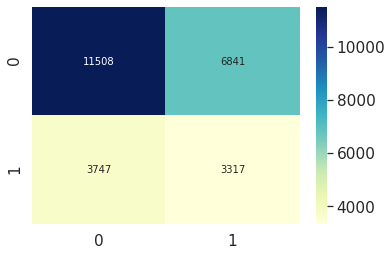

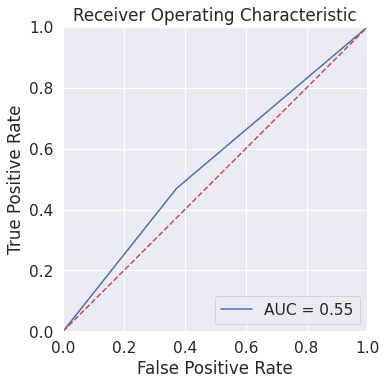

In [ ]:
reshaped_bert_test = bert_test.reshape(-1, 768, 1)
bert_LSTM = load_model(main_path + data_folder_name + "bert_LSTM.hdf5")
y_pred = (bert_LSTM.predict(reshaped_bert_test) > 0.5).astype("int32")
display_results(y_pred, y_test)

## Agree/Disagree/Discuss Classification

### Retrieve data from output of previous model

In [ ]:
print()
X_test.iloc[]

,Headline,articleBody
2,appl keep gold watch edit special instor safe,alsisi deni isra report state offer extend gaz...
3,appl store keep gold “ edit ” appl watch custo...,alsisi deni isra report state offer extend gaz...
